In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from yellowbrick.model_selection import LearningCurve
from sklearn.inspection import permutation_importance

import warnings
warnings.filterwarnings("ignore")

In [40]:
data = pd.read_csv("wanshouxigong_20130301-20170228.csv")
data = data.drop(["No", "PM10", "SO2", "NO2", "CO", "O3", "station"], axis=1).dropna()
## lag variable
data["lag1"] = data["PM2.5"].shift(1)
data["lag2"] = data["PM2.5"].shift(2)
data["lag3"] = data["PM2.5"].shift(3)
data["lag4"] = data["PM2.5"].shift(4)
data["wd"] = data["wd"].str.contains("N").astype(int) # clean "wd"
data = data.dropna()
data

,year,month,day,hour,PM2.5,TEMP,PRES,DEWP,RAIN,wd,WSPM,lag1,lag2,lag3,lag4
4,2013,3,1,4,8.0,-0.9,1024.1,-21.7,0.0,1,2.5,8.0,8.0,11.0,9.0
5,2013,3,1,5,10.0,-1.6,1024.7,-21.1,0.0,1,2.0,8.0,8.0,8.0,11.0
6,2013,3,1,6,8.0,-2.4,1025.4,-20.3,0.0,1,2.3,10.0,8.0,8.0,8.0
7,2013,3,1,7,8.0,-0.8,1026.7,-19.9,0.0,1,2.0,8.0,10.0,8.0,8.0
8,2013,3,1,8,3.0,0.4,1027.3,-19.4,0.0,1,2.7,8.0,8.0,10.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,2017,2,28,19,11.0,12.5,1013.5,-16.2,0.0,1,2.4,11.0,11.0,6.0,11.0
35060,2017,2,28,20,13.0,11.6,1013.6,-15.1,0.0,1,0.9,11.0,11.0,11.0,6.0
35061,2017,2,28,21,14.0,10.8,1014.2,-13.3,0.0,1,1.1,13.0,11.0,11.0,11.0
35062,2017,2,28,22,12.0,10.5,1014.4,-12.9,0.0,1,1.2,14.0,13.0,11.0,11.0


In [41]:
# train test split
X_train = data.loc[data["year"] < 2017, "TEMP":"lag4"]
y_train = data.loc[data["year"] < 2017, "PM2.5"]
X_test = data.loc[data["year"] == 2017, "TEMP":"lag4"]
y_test = data.loc[data["year"] == 2017, "PM2.5"]

In [42]:
rf = RandomForestRegressor()

params = {
    'max_depth': [2,5,10,None],
    'min_samples_leaf': [1,2,5,10],
}
# grid search
gs = GridSearchCV(rf, params)
gs.fit(X_train, y_train)

tuned_rf = RandomForestRegressor(**gs.best_params_)

In [43]:
print(gs.best_params_)

{'max_depth': 10, 'min_samples_leaf': 5}


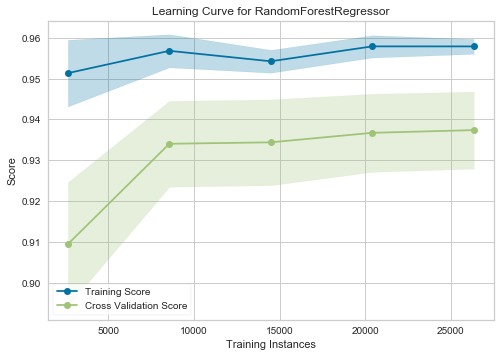

In [44]:
# Figure 7: Learning Curve for Random Forest
lc_viz = LearningCurve(tuned_rf)
lc_viz.fit(X_train, y_train)
lc_viz.show();

In [45]:
def rmse(y_pred, y):
    return np.sqrt(((y-y_pred)**2).mean())

tuned_rf.fit(X_train, y_train)

print(rmse(tuned_rf.predict(X_train), y_train))
print(rmse(tuned_rf.predict(X_test), y_test))

17.322910561712032
32.93188907248435


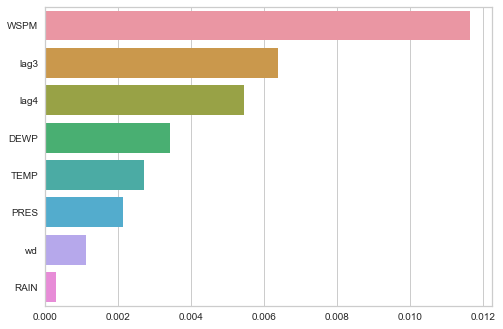

In [51]:
importances = permutation_importance(tuned_rf, X_train, y_train)
idx = np.argsort(-importances['importances_mean'])[2:]
# Figure 8: Feature Importance for Random Forest
sns.barplot(importances['importances_mean'][idx], X_train.columns[idx]);